# MELANOMA EFFICIENTNET-B7 WITH TPUS

### 512 * 512 Efficientnet-b7
* ME7-v1 epochs 15 
* ME7-v4 epochs 20 fold 1 ***(LB - 0.900)***
* ME7-v5 epochs 25 save best 3 fold 2 **(LB 0.886)**
* ME7-v7 fold3 **(LB 0.892)**
* ME7-v9 fold4 **(LB 0.899)** 
* ME7-v10 fold5 **(LB 0.890)**
* Combined **(LB 0.905)**


# MELANOMA EFFICIENTNET-B3 WITH TPUS (ME3)

### 224 * 224 Efficientnet-b3
* tried without random blackout val auc in range - (0.84-0.86)
* tried with random blackout val auc in range - (0.90-0.91)
* ME7-v12 lr changed, random blackout combined ***(LB - 0.916)***
* 
* 
* To do : Colorjitter, normalize


# <span style="color:red">**Do upvote if you find this notebook helpful :)**</span>

In [1]:
colab=0
show_files=0
tstamp=0
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
if (not colab)&show_files:
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output

### Loading libraries

In [2]:
!pip install -q efficientnet

In [3]:
import math
import pytz
import random
import numpy as np
import pandas as pd
import math, re, os, gc
import tensorflow as tf
from pathlib import Path
from datetime import datetime
from scipy.stats import rankdata
import efficientnet.tfkeras as efn
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

if not colab:
    from kaggle_datasets import KaggleDatasets

Tensorflow version 2.2.0


In [4]:
if colab:
    PATH=Path('/content/gdrive/My Drive/kaggle/input/siim-isic-melanoma-classification/') 
    train=pd.read_csv(PATH/'train.csv.zip')
else:
    PATH=Path('/kaggle/input/siim-isic-melanoma-classification/')
    train=pd.read_csv(PATH/'train.csv')
test=pd.read_csv(PATH/'test.csv')
sub=pd.read_csv(PATH/'sample_submission.csv')

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
SEED=121
seed_everything(SEED)

## TPU INITIALIZATION

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
IMAGE_SIZE = [224, 224]
EPOCHS=25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
CLASSES = ['benign', 'malignant']
NAME='EffNB0_224'
NFOLDS=5
NBEST=3

In [7]:
if colab: 
    SAVE_FOLDER=NAME
    if tstamp:
        time_zone = pytz.timezone('America/Chicago')
        current_datetime = datetime.now(time_zone)
        ts=current_datetime.strftime("%m%d%H%M%S")
        SAVE_FOLDER+='_'+ts
    SAVE_FOLDER=PATH/SAVE_FOLDER
    if not os.path.exists(SAVE_FOLDER):
        os.mkdir(SAVE_FOLDER)
else:
    SAVE_FOLDER=Path('/kaggle/working')

## DATA LOADING AND SPLITTING


In [8]:
GCS_PATH={}

if colab:
    GCS_PATH['train']='gs://kds-4169ce1e5a624d4b5bd866480682658f2063b18c5cf995cd3316a7e9'
    GCS_PATH['test']='gs://kds-147ff1400c195e2f8c7b01492e04fd2769e0305e9ef6c01afc9c5870'
else:
    GCS_PATH['train']=KaggleDatasets().get_gcs_path('siim-tfrec-224-train')
    GCS_PATH['test']=KaggleDatasets().get_gcs_path('siim-tfrec-224-test')

print(GCS_PATH['train'])
print(GCS_PATH['test'])

gs://kds-7c85e56b75c90b3d85d6400b35c28267245179f66bd33592eaa75e51
gs://kds-51420f3554169f9b2799f417a50baae3c9a3fd8527e7d1657f14cc44


In [9]:
ALL_TRAIN=tf.io.gfile.glob(GCS_PATH['train'] + '/*.tfrec')

VAL_FNAMES={}
for fn in range(1, NFOLDS+1):
    VAL_FNAMES[f"fold_{fn}"]=[path for path in ALL_TRAIN if f"fold_{fn}" in path]    
    print("Fold", f'{fn}:', len(VAL_FNAMES[f'fold_{fn}']), "elements in total.")
    
TRAIN_FNAMES={f'fold_{i}': list(set(ALL_TRAIN)-set(VAL_FNAMES[f'fold_{i}']))
              for i in range(1, NFOLDS+1)}

TEST_FNAMES = tf.io.gfile.glob(GCS_PATH['test'] + '/*.tfrec')

Fold 1: 4 elements in total.
Fold 2: 4 elements in total.
Fold 3: 4 elements in total.
Fold 4: 4 elements in total.
Fold 5: 4 elements in total.


In [10]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

N_TRAIN_IMGS = {f'fold_{i}': count_data_items(TRAIN_FNAMES[f'fold_{i}'])
                for i in range(1, NFOLDS+1)}

N_VAL_IMGS = {f'fold_{i}': count_data_items(VAL_FNAMES[f'fold_{i}'])
              for i in range(1, NFOLDS+1)}

N_TEST_IMGS = count_data_items(TEST_FNAMES)

STEPS_PER_EPOCH = {f'fold_{i}': N_TRAIN_IMGS[f'fold_{i}'] // BATCH_SIZE
                   for i in range(1, NFOLDS+1)}

print("="*75)

print(f"The number of unlabeled test image is {N_TEST_IMGS}. It is common for all folds.")

for i in range(1, NFOLDS+1):
    print("="*75)
    print(f"Fold {i}: {N_TRAIN_IMGS[f'fold_{i}']} training and {N_VAL_IMGS[f'fold_{i}']} validation images.")
print("="*75)

The number of unlabeled test image is 10982. It is common for all folds.
Fold 1: 26502 training and 6624 validation images.
Fold 2: 26496 training and 6630 validation images.
Fold 3: 26492 training and 6634 validation images.
Fold 4: 26504 training and 6622 validation images.
Fold 5: 26510 training and 6616 validation images.


In [11]:
# functions for visualization
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(databatch):
    if len(databatch)==4:
        images, labels, _, _ = databatch
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
    else:
        images, _ = databatch
        numpy_images = images.numpy()
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" 
                                if not correct else '', 
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), 
                  color='red' if red else 'black', fontdict={'verticalalignment':'center'}, 
                  pad=int(titlesize/1.5)
                 )
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does  
    # not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        # magic formula tested to work from 1x1 to 10x10 images
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
        subplot = display_one_image(image, title, subplot, 
                                     not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

## DATASETS

In [12]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.string),
        "benign_malignant": tf.io.FixedLenFeature([], tf.string),
        "age": tf.io.FixedLenFeature([], tf.int64),
        "sex_female": tf.io.FixedLenFeature([], tf.int64),        
        "sex_male": tf.io.FixedLenFeature([], tf.int64),
        "sex_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_head/neck": tf.io.FixedLenFeature([], tf.int64),
        "site_lower extremity": tf.io.FixedLenFeature([], tf.int64),
        "site_oral/genital": tf.io.FixedLenFeature([], tf.int64),
        "site_palms/soles": tf.io.FixedLenFeature([], tf.int64),
        "site_torso": tf.io.FixedLenFeature([], tf.int64),
        "site_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_upper extremity": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64), 
        "age_scaled": tf.io.FixedLenFeature([], tf.float32),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image']) 
    
    data={}
    data['image_name']=image_name=tf.cast(example['image_name'], tf.string)
    data['patient_id']=tf.cast(example['patient_id'], tf.string)
    data['age']=tf.cast(example['age'], tf.int32)
    data['sex_female']=tf.cast(example['sex_female'], tf.int32)
    data['sex_male']=tf.cast(example['sex_male'], tf.int32)
    data['sex_unknown']=tf.cast(example['sex_unknown'], tf.int32)
    data['site_head/neck']=tf.cast(example['site_head/neck'], tf.int32)
    data['site_lower extremity']=tf.cast(example['site_lower extremity'], tf.int32)
    data['site_oral/genital']=tf.cast(example['site_oral/genital'], tf.int32)
    data['site_palms/soles']=tf.cast(example['site_palms/soles'], tf.int32)
    data['site_torso']=tf.cast(example['site_torso'], tf.int32)
    data['site_unknown']=tf.cast(example['site_unknown'], tf.int32)
    data['site_upper extremity']=tf.cast(example['site_upper extremity'], tf.int32)
    data['age_scaled']=tf.cast(example['age_scaled'], tf.float32)
    
    label=tf.cast(example['target'], tf.int32)
    label_name=tf.cast(example['benign_malignant'], tf.string)
    
    return image, label, data, label_name

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.string),
        "age": tf.io.FixedLenFeature([], tf.int64),
        "sex_female": tf.io.FixedLenFeature([], tf.int64),        
        "sex_male": tf.io.FixedLenFeature([], tf.int64),
        "sex_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_head/neck": tf.io.FixedLenFeature([], tf.int64),
        "site_lower extremity": tf.io.FixedLenFeature([], tf.int64),
        "site_oral/genital": tf.io.FixedLenFeature([], tf.int64),
        "site_palms/soles": tf.io.FixedLenFeature([], tf.int64),
        "site_torso": tf.io.FixedLenFeature([], tf.int64),
        "site_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_upper extremity": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64), 
        "age_scaled": tf.io.FixedLenFeature([], tf.float32),
    }

    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image']) 
    
    data={}
    data['image_name']=image_name=tf.cast(example['image_name'], tf.string)
    data['patient_id']=tf.cast(example['patient_id'], tf.string)
    data['age']=tf.cast(example['age'], tf.int32)
    data['sex_female']=tf.cast(example['sex_female'], tf.int32)
    data['sex_male']=tf.cast(example['sex_male'], tf.int32)
    data['sex_unknown']=tf.cast(example['sex_unknown'], tf.int32)
    data['site_head/neck']=tf.cast(example['site_head/neck'], tf.int32)
    data['site_lower extremity']=tf.cast(example['site_lower extremity'], tf.int32)
    data['site_oral/genital']=tf.cast(example['site_oral/genital'], tf.int32)
    data['site_palms/soles']=tf.cast(example['site_palms/soles'], tf.int32)
    data['site_torso']=tf.cast(example['site_torso'], tf.int32)
    data['site_unknown']=tf.cast(example['site_unknown'], tf.int32)
    data['site_upper extremity']=tf.cast(example['site_upper extremity'], tf.int32)
    data['age_scaled']=tf.cast(example['age_scaled'], tf.float32)

    return image, data

In [13]:
img_size=IMAGE_SIZE[0]
def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):

    h, w, c = img_size, img_size, 3
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cast(erased_img, img.dtype)

In [17]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled 
                          else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FNAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def data_augment(data, label):
    data['inp1'] = tf.image.random_flip_left_right(data['inp1'])
    data['inp1'] = tf.image.random_flip_up_down(data['inp1'])
    data['inp1'] = random_blockout(data['inp1'])
    #data['inp1'] = tf.image.rgb_to_hsv(data['inp1'])
    #data['inp1'] = tf.image.rgb_to_grayscale(data['inp1'])
    #data['inp1'] = tf.image.random_saturation(data['inp1'], 0, 2)
    #data['inp1'] = tf.image.adjust_brightness(data['inp1'], 1)
    
    return data, label

def get_training_dataset(dataset):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(dataset):
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def setup_input(image, label, data, label_name):
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular=tf.stack(tab_data)
    return {'inp1': image, 'inp2':  tabular}, label

tab_feats=['age_scaled',
           'sex_female', 
           'sex_male', 
           'sex_unknown', 
           'site_head/neck', 
           'site_lower extremity', 
           'site_oral/genital',
           'site_palms/soles',
           'site_torso',
           'site_unknown',
           'site_upper extremity',
          ]
N_TAB_FEATS=len(tab_feats)
print(f"The number of tabular features is {N_TAB_FEATS}.")

def unroll_for_visualization(data, label):
    return data['inp1'], label, data['inp2'], label

The number of tabular features is 11.


## DATASET VISUALIZATIONS

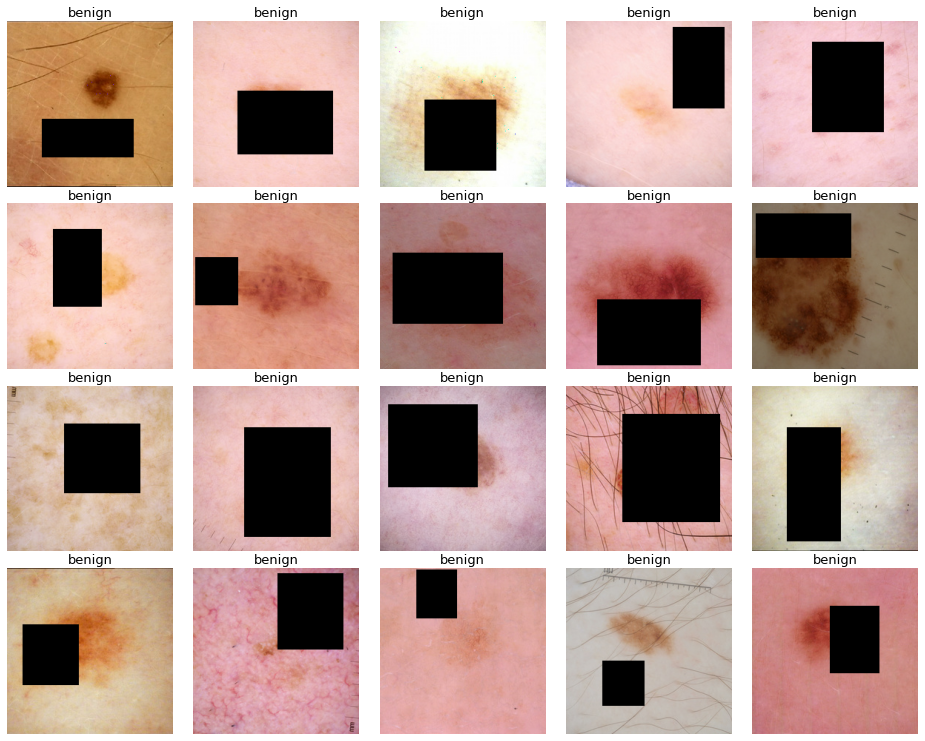

42527

In [15]:
training_dataset = load_dataset(TRAIN_FNAMES['fold_1'])
training_dataset = training_dataset.map(setup_input, num_parallel_calls=AUTO)
training_dataset = get_training_dataset(training_dataset).unbatch().filter(lambda data, label:label==0)
training_dataset = training_dataset.map(unroll_for_visualization, num_parallel_calls=AUTO)
training_dataset = training_dataset.batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))

del training_dataset, train_batch
gc.collect()

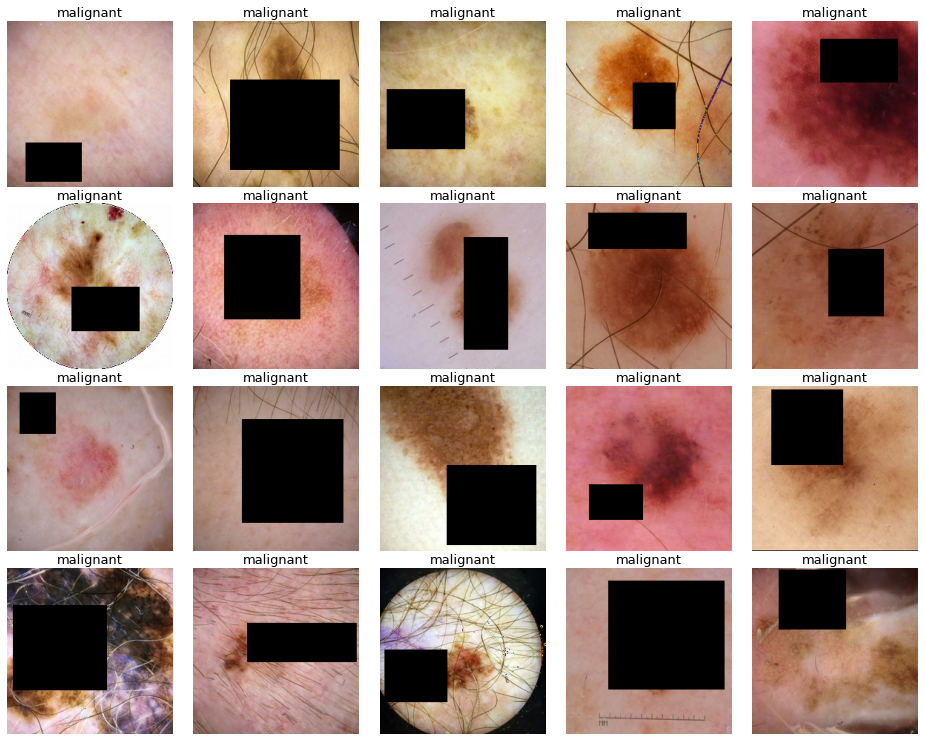

42535

In [16]:
training_dataset = load_dataset(TRAIN_FNAMES['fold_1'])
training_dataset = training_dataset.map(setup_input, num_parallel_calls=AUTO)
training_dataset = get_training_dataset(training_dataset).unbatch().filter(lambda data, label:label==1)
training_dataset = training_dataset.map(unroll_for_visualization, num_parallel_calls=AUTO)
training_dataset = training_dataset.batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))

del training_dataset, train_batch
gc.collect()

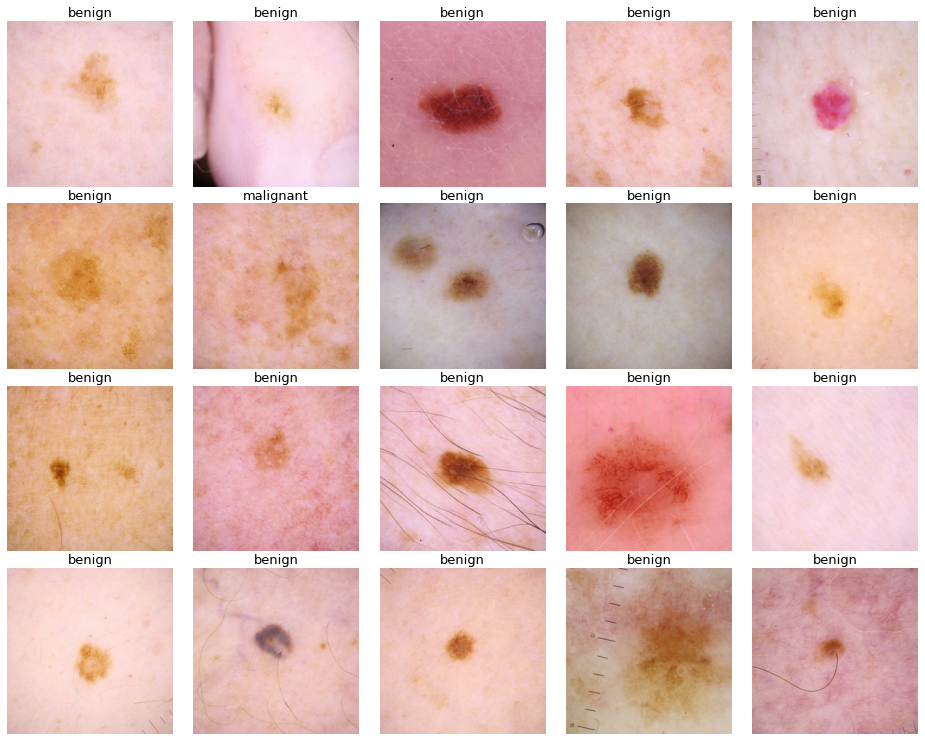

41321

In [19]:
validation_dataset = load_dataset(VAL_FNAMES['fold_1'])
validation_dataset = validation_dataset.map(setup_input, num_parallel_calls=AUTO)
validation_dataset = get_validation_dataset(validation_dataset)
validation_dataset = validation_dataset.map(unroll_for_visualization, num_parallel_calls=AUTO)
validation_dataset = validation_dataset.unbatch().batch(20)
validation_batch = iter(validation_dataset)
display_batch_of_images(next(validation_batch))

del validation_dataset, validation_batch
gc.collect()

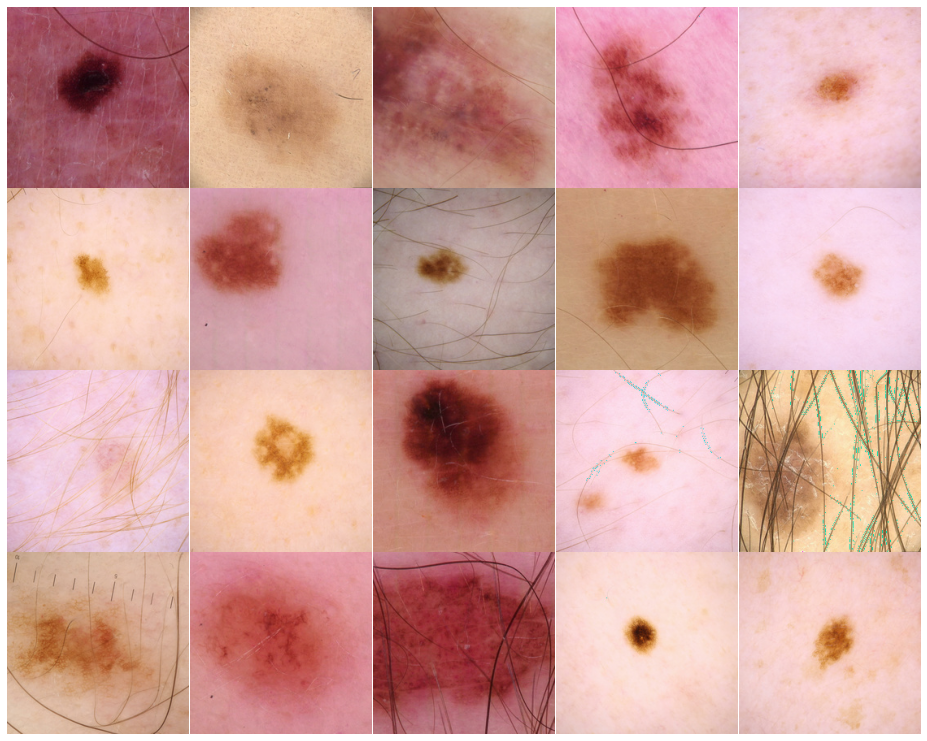

45034

In [17]:
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)
display_batch_of_images(next(test_batch))

del test_dataset, test_batch
gc.collect()

## CREATING MODEL AND CALLBACKS

In [20]:
def get_model():
    with strategy.scope():
        pretrained_model = efn.EfficientNetB3(input_shape=(*IMAGE_SIZE, 3),
                                              weights='noisy-student',
                                              include_top=False
                                             )
        pretrained_model.trainable = True
        inp1 = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name='inp1')
        inp2 = tf.keras.layers.Input(shape=(N_TAB_FEATS), name='inp2')
        
        x=pretrained_model(inp1)
        x=tf.keras.layers.GlobalAveragePooling2D()(x)
        x=tf.keras.layers.Dense(512, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(256, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(128, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        y=tf.keras.layers.Dense(100, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(inp2)
        
        concat=tf.keras.layers.concatenate([y, x])
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(concat)
        model = tf.keras.models.Model(inputs=[inp1,inp2], outputs=[output])
    
        model.compile(optimizer='adam',
                      loss = 'binary_crossentropy', 
                      metrics=[tf.keras.metrics.AUC()])
        
        return model
    
model=get_model()
model.summary()

43933696/43933088 [==============================] - 10s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b3 (Model)         (None, 7, 7, 1536)   10783528    inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1536)         0           efficientnet-b3[1][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          786944      global_average_pooling2d[0][0]   
____________________________

In [21]:
del model
gc.collect()

965

Learning rate schedule: 0.0001 to 0.0004 to 2.72e-05


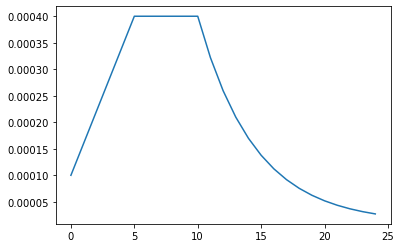

In [22]:
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 5
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [23]:
train['target'].values
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train['target'].values),
                                                  y=train['target'].values)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 0.5089730194825149, 1: 28.361301369863014}


In [24]:
class save_best_n(tf.keras.callbacks.Callback):
    def __init__(self, fn, model):
        self.fn = fn
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if (epoch>0):
            score=logs.get("val_auc")
        else:
            score=-1
        if (score > best_score[fold_num].min()):
            idx_min=np.argmin(best_score[fold_num])
            best_score[fold_num][idx_min]=score
            best_epoch[fold_num][idx_min]=epoch+1
            path_best_model=f'best_model_fold_{self.fn}_{idx_min}.hdf5'
            self.model.save(SAVE_FOLDER/path_best_model)

## TRAINING

In [25]:
# keep start train=1 for smal models remove break also
start_train = 1


In [26]:
%%time

debug=0 
histories = []
best_epoch={fn: np.zeros(NBEST) for fn in range(1, NFOLDS+1)}
best_score={fn: np.zeros(NBEST) for fn in range(1, NFOLDS+1)}

for fold_num in range(start_train, NFOLDS+1):
    
    tf.keras.backend.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    print("="*50)
    print(f"Starting fold {fold_num} out of {NFOLDS}...")
    
    files_trn=TRAIN_FNAMES[f"fold_{fold_num}"]
    files_val=VAL_FNAMES[f"fold_{fold_num}"]
    
    if debug:
        files_trn=files_trn[0:2]
        files_val=files_val[0:2]
        EPOCHS=3
       
    train_dataset = load_dataset(files_trn)
    train_dataset = train_dataset.map(setup_input, num_parallel_calls=AUTO)
    val_dataset = load_dataset(files_val, ordered = True)
    val_dataset = val_dataset.map(setup_input, num_parallel_calls=AUTO)
    
    model = get_model()
    STEPS_PER_EPOCH = count_data_items(files_trn) // BATCH_SIZE
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    history = model.fit(get_training_dataset(train_dataset), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        callbacks=[lr_callback, save_best_n(fold_num, model)],
                        validation_data=get_validation_dataset(val_dataset),
                        class_weight=class_weights,
                        verbose=1,
                       )
    
    idx_sorted=np.argsort(best_score[fold_num])
    best_score[fold_num]=np.array(best_score[fold_num])[idx_sorted]
    best_epoch[fold_num]=np.array(best_epoch[fold_num])[idx_sorted]
    print(f"\nFold {fold_num} is finished. The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}")
    print(f"The corresponding scores: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}")
    print()
    histories.append(history)

Starting fold 1 out of 5...

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/25
207/207 [==============================] - 48s 232ms/step - loss: 10.7133 - auc: 0.7469 - val_loss: 7.7652 - val_auc: 0.8072 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00016.
Epoch 2/25
207/207 [==============================] - 35s 169ms/step - loss: 4.9366 - auc: 0.8453 - val_loss: 3.0157 - val_auc: 0.8567 - lr: 1.6000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00022000000000000003.
Epoch 3/25
207/207 [==============================] - 35s 168ms/step - loss: 1.9784 - auc: 0.8511 - val_loss: 1.5979 - val_auc: 0.8431 - lr: 2.2000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00028000000000000003.
Epoch 4/25
207/207 [==============================] - 35s 168ms/step - loss: 0.9886 - auc: 0.8516 - val_loss: 1.0322 - val_auc: 0.8546 - lr: 2.8000e-04

Epoch 00005: LearningRateScheduler reducing learn

207/207 [==============================] - 31s 148ms/step - loss: 0.4852 - auc: 0.8814 - val_loss: 0.4628 - val_auc: 0.8857 - lr: 4.0000e-04

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 11/25
207/207 [==============================] - 31s 148ms/step - loss: 0.4834 - auc: 0.8794 - val_loss: 0.2902 - val_auc: 0.8187 - lr: 4.0000e-04

Epoch 00012: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 12/25
207/207 [==============================] - 36s 173ms/step - loss: 0.4503 - auc: 0.8933 - val_loss: 0.4205 - val_auc: 0.9066 - lr: 3.2200e-04

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 13/25
207/207 [==============================] - 30s 147ms/step - loss: 0.4153 - auc: 0.9070 - val_loss: 0.3710 - val_auc: 0.9010 - lr: 2.5960e-04

Epoch 00014: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 14/25
207/207 [==============================] - 31s 149ms/step - loss: 0.4220 - 


Epoch 00020: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 20/25
206/206 [==============================] - 31s 152ms/step - loss: 0.3305 - auc: 0.9463 - val_loss: 0.3449 - val_auc: 0.8905 - lr: 6.2345e-05

Epoch 00021: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 21/25
206/206 [==============================] - 31s 148ms/step - loss: 0.3115 - auc: 0.9510 - val_loss: 0.2782 - val_auc: 0.8953 - lr: 5.1876e-05

Epoch 00022: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 22/25
206/206 [==============================] - 35s 170ms/step - loss: 0.3214 - auc: 0.9470 - val_loss: 0.3076 - val_auc: 0.9037 - lr: 4.3501e-05

Epoch 00023: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 23/25
206/206 [==============================] - 35s 169ms/step - loss: 0.2992 - auc: 0.9560 - val_loss: 0.3006 - val_auc: 0.9017 - lr: 3.6801e-05

Epoch 00024: LearningRateScheduler reducing 

207/207 [==============================] - 34s 166ms/step - loss: 1.8483 - auc: 0.8401 - val_loss: 1.3524 - val_auc: 0.8620 - lr: 2.2000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00028000000000000003.
Epoch 4/25
207/207 [==============================] - 34s 167ms/step - loss: 0.9620 - auc: 0.8599 - val_loss: 0.9724 - val_auc: 0.8734 - lr: 2.8000e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00034.
Epoch 5/25
207/207 [==============================] - 35s 171ms/step - loss: 0.6678 - auc: 0.8633 - val_loss: 0.5525 - val_auc: 0.8740 - lr: 3.4000e-04

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/25
207/207 [==============================] - 35s 167ms/step - loss: 0.5751 - auc: 0.8715 - val_loss: 0.6206 - val_auc: 0.8760 - lr: 4.0000e-04

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 7/25
207/207 [==============================] - 30s 146ms/step - loss: 0.5282 - auc: 0.8690 - val_lo

start 16:12

## TRAINING CURVES

In [31]:
start=1
# put same as start ake start to 0 for full train
NFOLDS=5
# SAVE_FOLDER='../input/me7v4models'   

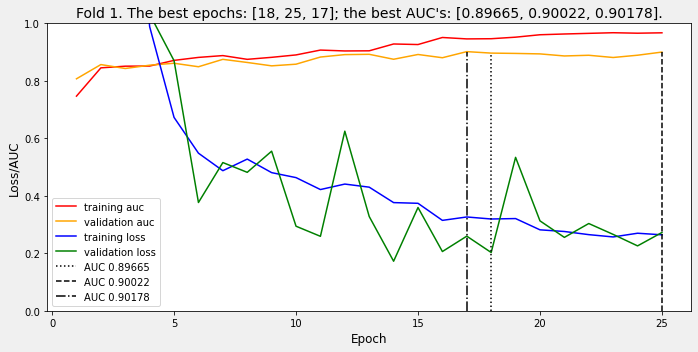

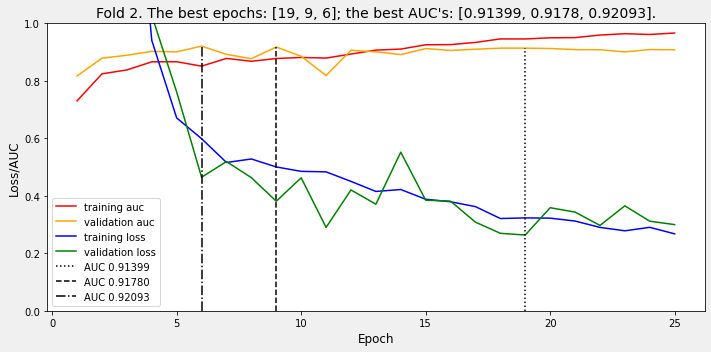

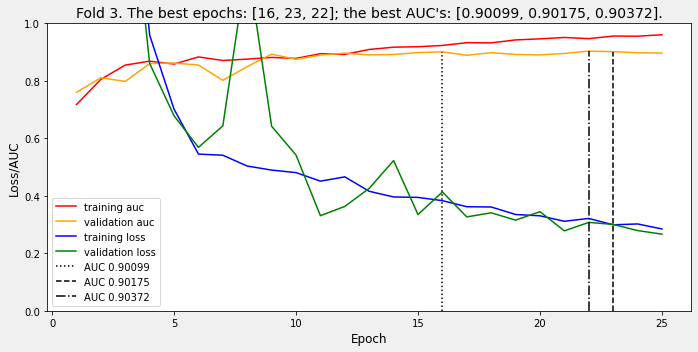

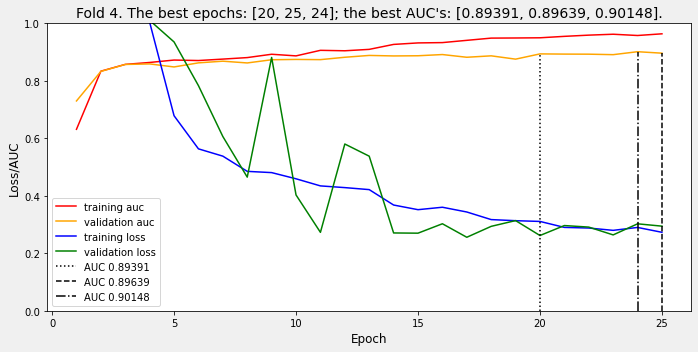

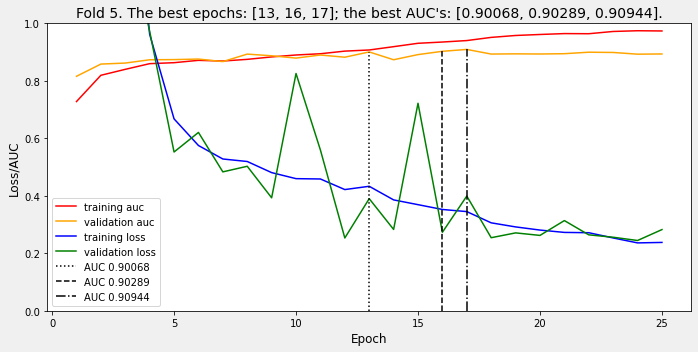

In [28]:
def display_training_curves(fold_num, data):

    plt.figure(figsize=(10,5), facecolor='#F0F0F0')
    epochs=np.arange(1, EPOCHS+1)
    plt.plot(epochs, data['auc'], label='training auc', color='red')
    plt.plot(epochs, data['val_auc'], label='validation auc', color='orange')
    plt.plot(epochs, data['loss'], label='training loss', color='blue')    
    plt.plot(epochs, data['val_loss'], label='validation loss', color='green')
    ls=['dotted', 'dashed', 'dashdot', 'solid']                                           
    for i in range(NBEST):
        plt.axvline(best_epoch[fold_num][i], 0, 
                    best_score[fold_num][i], linestyle=ls[i], 
                    color='black', label=f'AUC {best_score[fold_num][i]:.5f}')
    plt.title(f"Fold {fold_num}. The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}; the best AUC's: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}.", 
              fontsize='14')
    plt.ylabel('Loss/AUC', fontsize='12')
    plt.xlabel('Epoch', fontsize='12')
    plt.ylim((0, 1))
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

for fn in range(1, NFOLDS+1):
    display_training_curves(fn, data=histories[fn-1].history)

## PREDICTIONS

In [32]:
def setup_test_image(image, data):    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular=tf.stack(tab_data)
    return {'inp1': image, 'inp2': tabular}

def setup_test_name(image, data):
    return data['image_name']

def get_test_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def average_predictions(X, fn):
    y_probas=[]
    for idx in range(NBEST):
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        gc.collect()
        print(f"Predicting: fold {fn}, model {idx+1} out of {NBEST}...")
        with strategy.scope():
            path_best_model=f'best_model_fold_{fn}_{idx}.hdf5'
            model=tf.keras.models.load_model(os.path.join(SAVE_FOLDER,path_best_model))
        print('Predicting')
        y=model.predict(X, verbose=1)
        y = rankdata(y)/len(y)
        y_probas.append(y)
    y_probas=np.average(y_probas, axis=0)
    return y_probas

if colab:
    OUT_FOLDER=SAVE_FOLDER
else:
    OUT_FOLDER=Path('')

In [33]:
%%time

preds = pd.DataFrame({'image_name': np.zeros(len(test)), 'target': np.zeros(len(test))})
test_ds = load_dataset(TEST_FNAMES, labeled=False, ordered=True)
test_images_ds = test_ds.map(setup_test_image, num_parallel_calls=AUTO)
test_images_ds = get_test_dataset(test_images_ds)
test_ds = get_test_dataset(test_ds)
test_ids_ds = test_ds.map(setup_test_name, num_parallel_calls=AUTO).unbatch()
preds['image_name'] = next(iter(test_ids_ds.batch(N_TEST_IMGS))).numpy().astype('U')
predictions_list = [average_predictions(test_images_ds, fn) for fn in range(start, NFOLDS+1)]

Predicting: fold 1, model 1 out of 3...
Predicting
86/86 [==============================] - 9s 100ms/step
Predicting: fold 1, model 2 out of 3...
Predicting
86/86 [==============================] - 8s 98ms/step
Predicting: fold 1, model 3 out of 3...
Predicting
86/86 [==============================] - 9s 100ms/step
Predicting: fold 2, model 1 out of 3...
Predicting
86/86 [==============================] - 8s 96ms/step
Predicting: fold 2, model 2 out of 3...
Predicting
86/86 [==============================] - 8s 97ms/step
Predicting: fold 2, model 3 out of 3...
Predicting
86/86 [==============================] - 8s 98ms/step
Predicting: fold 3, model 1 out of 3...
Predicting
86/86 [==============================] - 8s 98ms/step
Predicting: fold 3, model 2 out of 3...
Predicting
86/86 [==============================] - 8s 97ms/step
Predicting: fold 3, model 3 out of 3...
Predicting
86/86 [==============================] - 9s 99ms/step
Predicting: fold 4, model 1 out of 3...
Predicting
86

In [34]:
PATH=Path('/kaggle/input/siim-isic-melanoma-classification/')
sub=pd.read_csv(PATH/'sample_submission.csv')
for fold_n in range(start, NFOLDS+1):
    del sub['target']
    preds['target'] = predictions_list[NFOLDS-fold_n]
    sub = sub.merge(preds, on='image_name')
    sub.to_csv(OUT_FOLDER/f'submission_ME7_v11_fold{fold_n}.csv', index=False)
    print(sub.head)
del sub['target']
preds['target'] = np.average(predictions_list, axis = 0)
sub = sub.merge(preds, on='image_name')
print(sub.head)
sub.to_csv(OUT_FOLDER/f'submission_ME7_v11_combined.csv', index=False)

<bound method NDFrame.head of          image_name    target
0      ISIC_0052060  0.500152
1      ISIC_0052349  0.042585
2      ISIC_0058510  0.013522
3      ISIC_0073313  0.286469
4      ISIC_0073502  0.639956
...             ...       ...
10977  ISIC_9992485  0.120986
10978  ISIC_9996992  0.778243
10979  ISIC_9997917  0.834426
10980  ISIC_9998234  0.321405
10981  ISIC_9999302  0.577733

[10982 rows x 2 columns]>
<bound method NDFrame.head of          image_name    target
0      ISIC_0052060  0.293981
1      ISIC_0052349  0.163085
2      ISIC_0058510  0.070130
3      ISIC_0073313  0.141201
4      ISIC_0073502  0.600983
...             ...       ...
10977  ISIC_9992485  0.297563
10978  ISIC_9996992  0.841195
10979  ISIC_9997917  0.940660
10980  ISIC_9998234  0.226659
10981  ISIC_9999302  0.193104

[10982 rows x 2 columns]>
<bound method NDFrame.head of          image_name    target
0      ISIC_0052060  0.334001
1      ISIC_0052349  0.085109
2      ISIC_0058510  0.127178
3      ISIC_0073